# Analysis of ProGen2 Candidates with AI4AMP and ESMFold

This notebook loads `candidates_scored_and_folded.csv`, ranks candidates by antimicrobial probability and structural confidence, and produces basic plots and summary tables.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Make plots a bit nicer
plt.rcParams["figure.figsize"] = (6, 4)
plt.rcParams["figure.dpi"] = 120

# Path to your results CSV
csv_path = "candidates_scored_and_folded.csv"

df = pd.read_csv(csv_path)
print("Loaded dataframe with shape:", df.shape)
df.head()

Loaded dataframe with shape: (539, 5)


,id,seq,ai4amp_score,pLDDT_mean,pdb_path
0,cand_1,MRSASPVAAANVAAGFAPGLRALFGYLLW,0.457963,0.571329,/jet/home/aqi/results/pdbs/cand_1.pdb
1,cand_2,MRSASVLANQAKTNLSGVAWTWFGWERQAYDLR,0.456459,0.504251,/jet/home/aqi/results/pdbs/cand_2.pdb
2,cand_3,MRSASASVTHPLLQGNNLRQVGAAAGAEGRY,0.457030,0.525237,/jet/home/aqi/results/pdbs/cand_3.pdb
3,cand_4,MRSASSLHAAPFWNFGISGVGRAVWLLSSSGAYKAYYYKR,0.457595,0.498219,/jet/home/aqi/results/pdbs/cand_4.pdb
4,cand_5,MRSAGRRRSARLLFWGWAF,0.458147,0.622783,/jet/home/aqi/results/pdbs/cand_5.pdb


In [2]:
print(df.columns)

# Basic statistics for scores
df[["ai4amp_score", "pLDDT_mean"]].describe()

Index(['id', 'seq', 'ai4amp_score', 'pLDDT_mean', 'pdb_path'], dtype='object')


,ai4amp_score,pLDDT_mean
count,539.000000,539.000000
mean,0.457218,0.569299
std,0.001159,0.085278
min,0.452572,0.415570
25%,0.456541,0.501933
50%,0.457217,0.551505
75%,0.457956,0.633462
max,0.460422,0.763069


In [3]:
# Top candidates by AI4AMP score
df_top_ai4amp = df.sort_values("ai4amp_score", ascending=False).head(20)
print("Top 20 by AI4AMP score:")
df_top_ai4amp[["id", "seq", "ai4amp_score", "pLDDT_mean"]]

# Top candidates by pLDDT_mean
df_top_plddt = df.sort_values("pLDDT_mean", ascending=False).head(20)
print("Top 20 by mean pLDDT:")
df_top_plddt[["id", "seq", "ai4amp_score", "pLDDT_mean"]]

# Combined score: average of normalized activity and structural confidence
df["combined_score"] = 0.5 * df["ai4amp_score"] + 0.5 * (df["pLDDT_mean"] / 100.0)

df_top_combined = df.sort_values("combined_score", ascending=False).head(20)
print("Top 20 by combined score:")
df_top_combined[["id", "seq", "ai4amp_score", "pLDDT_mean", "combined_score"]]

Top 20 by AI4AMP score:
Top 20 by mean pLDDT:
Top 20 by combined score:


,id,seq,ai4amp_score,pLDDT_mean,combined_score
36,cand_37,MRSARLLVAVANAFERGIVNLYGKLYT,0.459849,0.755896,0.233704
27,cand_28,MRSASHAASNNAFLGLLGGIYRVLVLGSS,0.460326,0.684484,0.233585
63,cand_64,MRSAHSAATRAAANSLSLLVAWAWGGRLS,0.459845,0.709934,0.233472
176,cand_177,MRSATRLGNIVLAVGARNATAILITTIRYGELLR,0.459197,0.747145,0.233334
388,cand_389,MRSASTAAAKHTAASYAFLRVIAGLLYLGR,0.459354,0.726130,0.233308
287,cand_288,MRSAAQADRHRLWTSFLHALASAAAAGELIRGQY,0.459261,0.734553,0.233303
8,cand_9,MRSASEGVHYFLSAPLLIRRAFFGWIAVYGRY,0.459531,0.706692,0.233299
317,cand_318,MRSAVQSSARAFLAFLAWSLAN,0.459234,0.736239,0.233298
444,cand_445,MRSAAHGAAAFFGVAAWVAAIFEVSRKLWWQR,0.459054,0.741242,0.233233
231,cand_232,MRSAAPLAAGFAAINAAKHVLLVEAYWQEWKK,0.459148,0.729848,0.233223


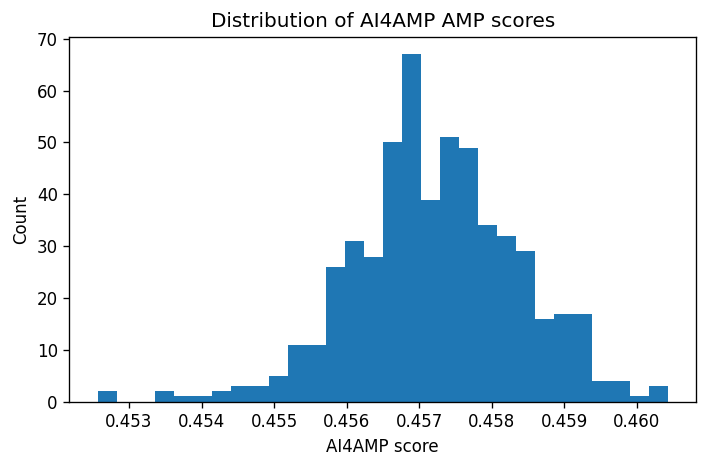

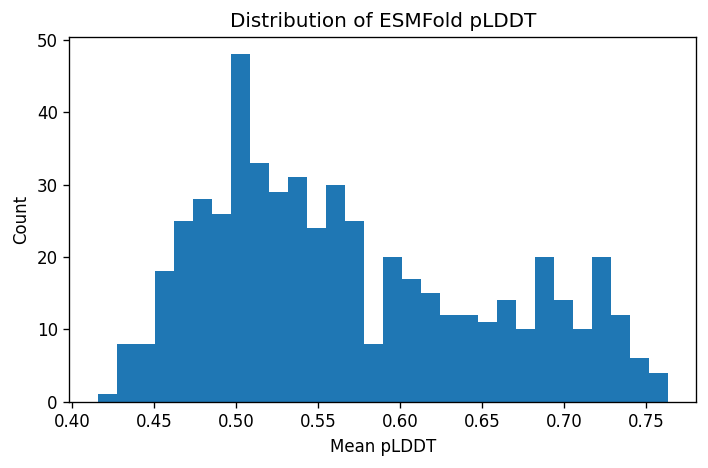

In [4]:
# AI4AMP distribution
plt.hist(df["ai4amp_score"], bins=30)
plt.xlabel("AI4AMP score")
plt.ylabel("Count")
plt.title("Distribution of AI4AMP AMP scores")
plt.tight_layout()
plt.show()

# pLDDT distribution
plt.hist(df["pLDDT_mean"], bins=30)
plt.xlabel("Mean pLDDT")
plt.ylabel("Count")
plt.title("Distribution of ESMFold pLDDT")
plt.tight_layout()
plt.show()

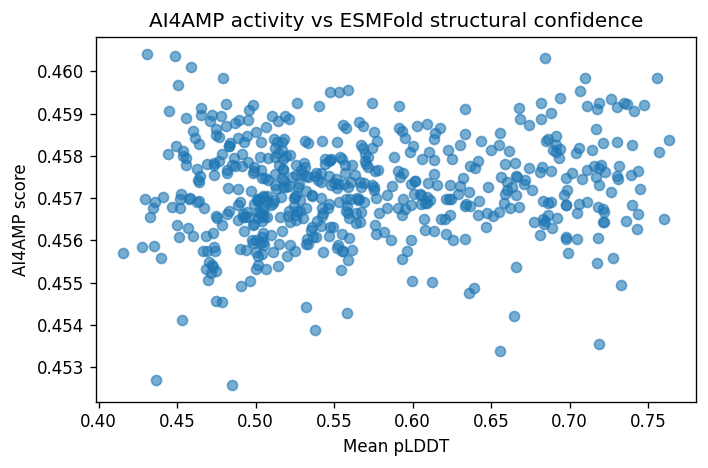

Number of high scoring and high confidence candidates: 56


,id,seq,ai4amp_score,pLDDT_mean
8,cand_9,MRSASEGVHYFLSAPLLIRRAFFGWIAVYGRY,0.459531,0.706692
13,cand_14,MRSAAAANNRRVTAIWWLCAAAWWRYLALWNY,0.453535,0.718993
24,cand_25,MRSARAASARGEAYAYAGLLRAFLF,0.457780,0.719680
36,cand_37,MRSARLLVAVANAFERGIVNLYGKLYT,0.459849,0.755896
37,cand_38,MRSAALWQQRAGNIIGHASYVAGALRL,0.458297,0.720964
45,cand_46,MRSASATANRLVSNHLLSWAYNEVRY,0.456643,0.704632
47,cand_48,MRSATTLAAAKLAAFRHRWILGVWNYWLHLWW,0.456430,0.721171
63,cand_64,MRSAHSAATRAAANSLSLLVAWAWGGRLS,0.459845,0.709934
76,cand_77,MRSALAARRRRLDSWFALHGIAGLEALYR,0.456669,0.722116
107,cand_108,MRSAALVRTFRFAGYILSVAAGVR,0.458140,0.714202


In [7]:
plt.scatter(df["pLDDT_mean"], df["ai4amp_score"], alpha=0.6)
plt.xlabel("Mean pLDDT")
plt.ylabel("AI4AMP score")
plt.title("AI4AMP activity vs ESMFold structural confidence")
plt.tight_layout()
plt.show()

mask = (df["pLDDT_mean"] > 0.7)
df_high = df[mask].copy()
print("Number of high scoring and high confidence candidates:", df_high.shape[0])
df_high[["id", "seq", "ai4amp_score", "pLDDT_mean"]].head(20)

Pareto front size: 5


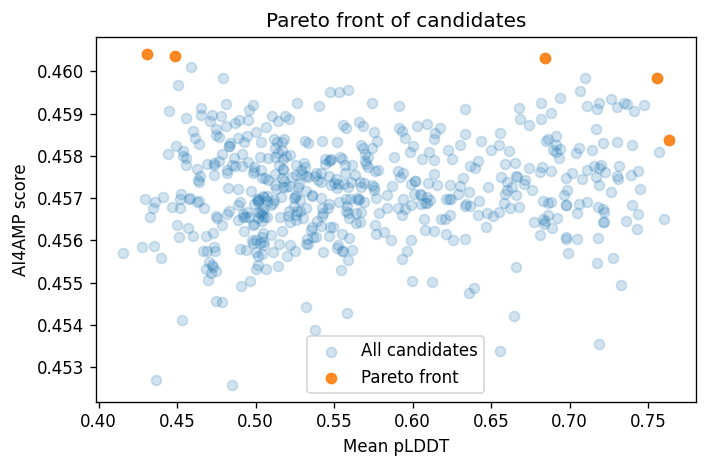

In [8]:
df_sorted = df.sort_values("pLDDT_mean", ascending=False).reset_index(drop=True)

pareto_rows = []
best_ai4amp = -1.0

for _, row in df_sorted.iterrows():
    score = row["ai4amp_score"]
    if score > best_ai4amp:
        pareto_rows.append(row)
        best_ai4amp = score

pareto_df = pd.DataFrame(pareto_rows)
print("Pareto front size:", pareto_df.shape[0])
pareto_df[["id", "seq", "ai4amp_score", "pLDDT_mean"]]

plt.scatter(df["pLDDT_mean"], df["ai4amp_score"], alpha=0.2, label="All candidates")
plt.scatter(pareto_df["pLDDT_mean"], pareto_df["ai4amp_score"], alpha=0.9, label="Pareto front")
plt.xlabel("Mean pLDDT")
plt.ylabel("AI4AMP score")
plt.title("Pareto front of candidates")
plt.legend()
plt.tight_layout()
plt.show()

In [9]:
# Save top by combined score for downstream analysis
out_top_path = "top_candidates.csv"
df_top_combined.to_csv(out_top_path, index=False)
print("Saved top candidates to:", out_top_path)

# Example thresholds, adjust as you like
thresh_ai4amp = 0.7
thresh_plddt = 70.0

df_filtered = df[
    (df["ai4amp_score"] >= thresh_ai4amp)
    & (df["pLDDT_mean"] >= thresh_plddt)
].copy()

print("Candidates passing thresholds:", df_filtered.shape[0])
df_filtered[["id", "seq", "ai4amp_score", "pLDDT_mean"]].head(20)

df_filtered.to_csv("candidates_passing_thresholds.csv", index=False)

Saved top candidates to: top_candidates.csv
Candidates passing thresholds: 0
